Author: Carlos Roberto de Melo

Obj: MGE parametrization for NFW profile.

## Sperical NFW

The classical spherical NFW profile is:
<center> $\rho(r) = \frac{\rho_s}{(r/r_s)  (1 + r/r_s)^2 }$.
    
    
But in terms of the critical surface density,
<center> $\Sigma_{crit} = \frac{c^2}{4\pi G} \frac{D_l}{D_s D_{ls}}$    
    
we have:
<center> $\rho(r) = \frac{\kappa_s \Sigma_{crit}}{r(1 + r/r_s)^2 }$,

where: $\kappa_s = \frac{\rho_s r_s}{\Sigma_{crit}}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mgefit import mge_fit_1d                                       #MGE 1-d parametrization
from jampy.mge_half_light_isophote import mge_half_light_isophote   #Compute half light radius
from jampy.mge_half_light_isophote import mge_half_light_radius     #Compute half light radius (other way)
from jampy import mge_radial_mass                                   #Compute mass inside some radius

from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
from astropy import table

from astropy.cosmology import Planck15
from astropy.constants import G, M_sun, c
import astropy.units as u
from scipy.integrate import quad

In [2]:
def Sph_NFW(rho_s, r_s, r):
    """
        Classical Spherical NFW profile.
    """
    return rho_s / ( (r/r_s) * (1 + r/r_s)**2 )



def Sph_NFW_lens(kappa_s, r_s, den_crit, r):
    """
        Classical Spherical NFW profile, usually used in lensing models. Here, the profile is writed in terms of
        kappa_s, which is a constant scale factor defined above in this notebook.
    """
    return (kappa_s * den_crit) / (r * (1 + r/r_s)**2 )

def Sph_NFW_lens_integral(r,
                          kappa_s, r_s, den_crit):
    """
        Integrant of classical Spherical NFW profile. Integrating this function you get the mass inside
        some radius.
    """
    return 4* np.pi * r**2 * (kappa_s * den_crit) / (r * (1 + r/r_s)**2 )

In [3]:
metre2Mpc = (1*u.m).to(u.Mpc)/u.m             #Constant factor to convert metre to Mpc.
kg2Msun   = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun


G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

In [4]:
#Redshift
z_l = 0.299 
z_s = 3.100

#Angular diametre distances
D_l  = Planck15.angular_diameter_distance(z_l)
D_s  = Planck15.angular_diameter_distance(z_s)
D_ls = Planck15.angular_diameter_distance_z1z2(z_l, z_s)

#Lens Critical Density
critical_density = ((c_Mpc**2/(4*np.pi*G_Mpc)) * (D_l/(D_ls * D_s))).to(u.solMass/u.pc**2)

In [5]:
kappa_s = 1.000                                                                #Lens scale factor [Ad]
r_s     = ( (10 * 1.15 * u.arcsec) * D_l ).to(u.pc, u.dimensionless_angles())  #Scale radius      [pc]
rho_s   = ( kappa_s * critical_density ) / r_s                                 #Scale density     [M_sun/pc^3]

r = np.logspace(-2.5, 7, 300) #Radii [pc]
print("Min: %.3e arcs, Max: %.3e arcs" %( r.min()/(D_l.value*np.pi/0.648), r.max()/(D_l.value*np.pi/0.648) ))

Min: 6.900e-07 arcs, Max: 2.182e+03 arcs


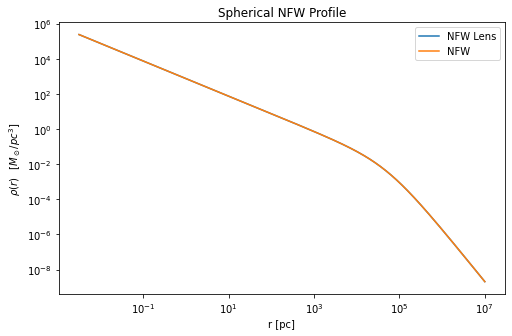

In [90]:
NFW_profile_lens = Sph_NFW_lens(kappa_s, r_s.value, critical_density.value, r)
NFW_profile      = Sph_NFW(rho_s.value, r_s.value, r)

plt.figure(figsize=(8,5))
plt.loglog(r, NFW_profile_lens, label="NFW Lens")
plt.loglog(r, NFW_profile, label="NFW")

plt.title("Spherical NFW Profile")
plt.xlabel("r [pc]")
plt.ylabel("$\\rho(r)$ $\\,$ [$M_\\odot$/$pc^3$]")
plt.legend()

In [91]:
Mass, err = quad(Sph_NFW_lens_integral, r.min(),r.max(), args=(kappa_s, r_s.value, critical_density.value))
print("Total mass between [%.3e, %.3e]pc: %.3e M_sun"% (r.min(), r.max(), Mass))

Total mass between [3.162e-03, 1.000e+07]pc: 1.105e+14 M_sun


## MGE parametrization

Iteration: 1  chi2: 0.01725 Nonzero: 40/40
Iteration: 11  chi2: 0.0005116 Nonzero: 40/40
Iteration: 21  chi2: 0.0004634 Nonzero: 40/40
Iteration: 31  chi2: 0.0004526 Nonzero: 40/40
Iteration: 41  chi2: 0.0004511 Nonzero: 40/40
Iteration: 47  chi2: 0.0004511 Nonzero: 40/40
############################################
 Computation time: 3.99 seconds
 Total Iterations:  47
Nonzero Gaussians:  40
 Unused Gaussians:  0
 Chi2: 0.0004511 
 STDEV: 0.001226
 MEANABSDEV: 0.0006294
############################################
 Total_Counts      Sigma
############################################
      1154.34   0.00223607
      1002.04   0.00459981
       917.76   0.00873352
      888.276     0.015993
       879.33     0.028953
      875.243    0.0522073
      872.354    0.0939251
      870.061     0.168686
      868.266      0.30254
      866.938      0.54204
      866.049     0.970413
      865.574      1.73653
      865.481       3.1069
      865.738        5.559
        866.3      9.94917
    

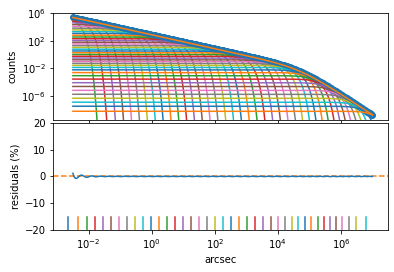

In [92]:
m = mge_fit_1d.mge_fit_1d(r, NFW_profile_lens, ngauss=40, outer_slope=2, plot=True)

In [81]:
#Converting quantities
surf  =  m.sol[0]                           # Surface density in Msun/pc**2
sigma = m.sol[1]/(D_l.value*np.pi/0.648)    # Gaussian dispersion in arcsec
qObs  = np.full_like(surf, 1)             # Assume spherical model

In [82]:
#Transforming Surface Density to Total Mass
distance  = D_l                        # Distance in Mpc
surf_dm   = surf * u.solMass/u.pc**2
sigma_ARC = sigma * u.arcsec           #sigma in arcsec
sigma_PC  = (sigma_ARC * distance).to(u.pc, u.dimensionless_angles()) #Convert sigma in arcsec to sigma in pc

#Total DM mass per gaussian in M_sun
Mass = 2 * np.pi * surf_dm * (sigma_PC**2) * qObs
print(f"Total mass:{Mass.sum():0.03e}")

Total mass:1.234e+14 solMass


In [83]:
mass_inside = mge_radial_mass.mge_radial_mass(surf_dm.value, sigma_ARC.value, qObs, 90,r.max()/(D_l.value*np.pi/0.648) ,D_l.value )

print("Mass inside [%.3e, %.3e]arcsec: %.3e M_sun"% (r.min()/(D_l.value*np.pi/0.648), r.max()/(D_l.value*np.pi/0.648), mass_inside) )

Mass inside [6.900e-07, 2.182e+03]arcsec: 1.105e+14 M_sun


In [84]:
np.savetxt('SphNFW_2e3arcsec.txt', np.column_stack([surf, sigma, qObs]),
                            fmt=b'%5.5e\t\t\t %5.5e\t\t %5.5e', 
                            header='Surface Potential(M_sun/pc²) Sigma Potential(arcsec)    qObs')

## Some plots in 2D

In [155]:
#Reading MGE parametrization
import mgetools as mge
mge2d                         = table.QTable.read("Sph-NFW.txt", format="ascii")    #DM component

In [156]:
mge3d = mge.Deproject(mge2d, inclination=80*u.deg, distance=D_l)
print(mge3d)

        i                   s            q 
  solMass / pc3             pc             
------------------ -------------------- ---
 617842.4528956532 0.002327033532180952 1.0
 265913.4596336318 0.005298912541135756 1.0
116928.06649911607 0.011962324967770138 1.0
 51745.73039114345 0.026854307410300014 1.0
 23031.18017848731 0.059984645129326566 1.0
 10304.32125151772  0.13340803976075424 1.0
 4631.200442539014  0.29564469740400423 1.0
 2089.324814713056   0.6533521167506268 1.0
 945.3543531057641   1.4409542289536745 1.0
 428.6476717488513    3.173751292239836 1.0
194.61698430162727    6.984611418860856 1.0
   88.421659053679    15.36268929900332 1.0
 40.18508505241878    33.76870238280086 1.0
 18.26856904442129     74.1461840303163 1.0
 8.315104410891541   162.52219841402209 1.0
3.8094815256316545    356.1280076354176 1.0
1.7788257770039142    791.0304347798942 1.0
0.8668134321305012   1878.1845237943814 1.0
 0.481214752017301    6478.658839638817 1.0


### Surface Density

First let's plot the surface density map in two dimensions (x and y) for the projected (2d) MGE.

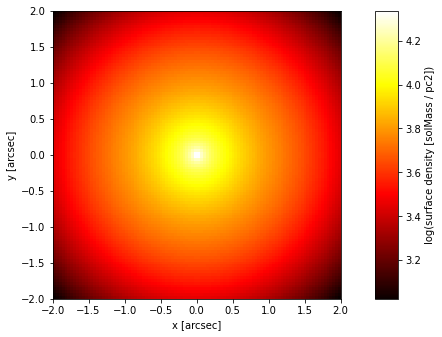

In [157]:
# full grid of R and z values, linear spacing
xy = np.linspace(-2, 2, 100)
x, y = np.meshgrid(xy, xy)*u.arcsec

# calculate surface density
surface_density = mge.SurfaceDensity(mge2d, x, y)

# plot log surface density map
fig = plt.figure(figsize=(8,5))
ax = fig.add_axes([0.20, 0.15, 0.60, 0.80])
plt.xlabel("x [{:}]".format(x.unit))
plt.ylabel("y [{:}]".format(y.unit))
cols = plt.imshow(np.log10(surface_density.value), origin="lower", aspect="equal", interpolation="nearest",
           extent=(x.min().value, x.max().value, y.min().value, y.max().value), cmap="hot")
cax = fig.add_axes([0.81, 0.15, 0.04, 0.80])
plt.colorbar(cols, cax=cax, orientation="vertical")
plt.ylabel("log(surface density [{:}])".format(surface_density.unit))
plt.show()

And now let's look at the surface densities along the major (x) and minor (y) axes.

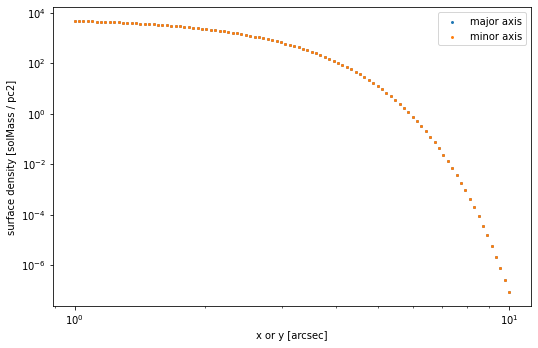

In [158]:
# quarter grid of R and z values, log spacing
log_xy = np.logspace(0, 1, 100)
log_x, log_y = np.meshgrid(log_xy, log_xy)*u.arcsec

# calculate surface density
surface_density = mge.SurfaceDensity(mge2d, log_x, log_y)

plt.figure(figsize=(8,5))
plt.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)
plt.loglog()
plt.scatter(log_x[0], surface_density[0], s=9, lw=0, label="major axis")
plt.scatter(log_y[:,0], surface_density[:,0], s=9, lw=0, label="minor axis")
plt.legend()
plt.xlabel("x or y [{:}]".format(log_x.unit))
plt.ylabel("surface density [{:}]".format(surface_density.unit))
plt.show()

### Volume Density

Now we consider the deprojected (3d) MGE. Again, let's start with the two dimensional density map in (R and z).

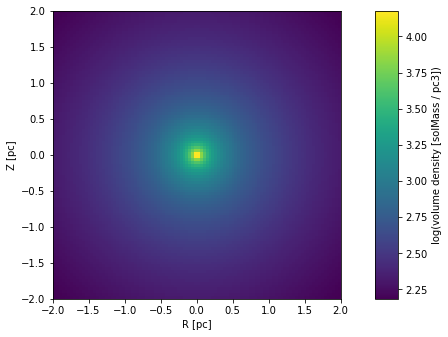

In [159]:
# full grid of R and z values, linear spacing
Rz = np.linspace(-10, 10, 100)
R, z = np.meshgrid(Rz, Rz)*u.pc

# calculate volume density
volume_density = mge.VolumeDensity(mge3d, R, z)

# plot log volume density map
fig = plt.figure(figsize=(8,5))
ax = fig.add_axes([0.20, 0.15, 0.60, 0.80])
plt.xlabel("R [{:}]".format(R.unit))
plt.ylabel("Z [{:}]".format(z.unit))
cols = plt.imshow(np.log10(volume_density.value), origin="lower", aspect="equal", interpolation="nearest",
           extent=(x.min().value, x.max().value, y.min().value, y.max().value))
cax = fig.add_axes([0.81, 0.15, 0.04, 0.80])
plt.colorbar(cols, cax=cax, orientation="vertical")
plt.ylabel("log(volume density [{:}])".format(volume_density.unit))
plt.show()

Again, we can also look at the density along the R and z axes separately, which is are slightly different due to the flattening of the MGE.

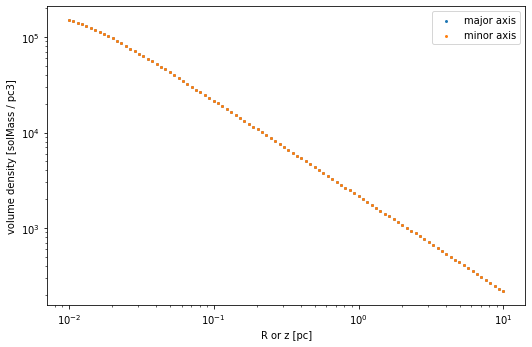

In [160]:
# quarter grid of R and z values, log spacing
log_Rz = np.logspace(-2, 1, 100)
log_R, log_z = np.meshgrid(log_Rz, log_Rz)*u.pc

# calculate volume density
volume_density = mge.VolumeDensity(mge3d, log_R, log_z)

plt.figure(figsize=(8,5))
plt.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)
plt.loglog()
plt.scatter(log_R[0], volume_density[0], s=9, lw=0, label="major axis")
plt.scatter(log_z[:,0], volume_density[:,0], s=9, lw=0, label="minor axis")
plt.legend()
plt.xlabel("R or z [{:}]".format(log_R.unit))
plt.ylabel("volume density [{:}]".format(volume_density.unit))
plt.show()

### 3D CumulativeProfile


And the cumulative profile for a deprojected (3d) MGE.

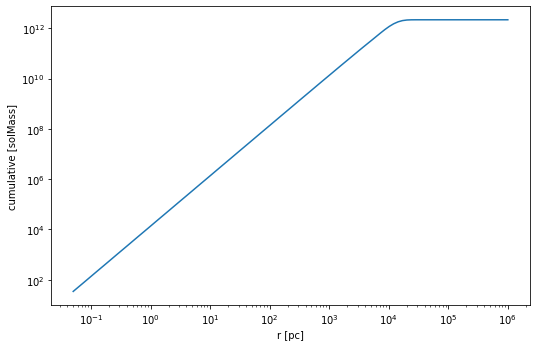

In [162]:
# array grid of radii, log spacing
r = np.logspace(-1.3, 6, 100)*u.pc

# calculate cumulative profile
cumulative = mge.Cumulative3D(r, mge3d)

plt.figure(figsize=(8,5))
plt.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)
plt.loglog()
plt.plot(r, cumulative)
plt.xlabel("r [{:}]".format(r.unit))
plt.ylabel("cumulative [{:}]".format(cumulative.unit))
plt.show()